# 3. Conservation Laws

In [23]:
import numpy as np
from scipy.integrate import nquad
from math import exp as exp
def integrand(vx,vy,vz,A0,v0):
    return A0*exp(-(vx**2+vy**2+vz**2)/v0**2)
I = nquad(integrand,[[-np.inf,np.inf],[-np.inf,np.inf],[-np.inf,np.inf]], args=(1e3,.1))
print('the value is',I[0],'particles/m^3 with error',I[1])

the value is 5.568327996831708 particles/m^3 with error 2.0286622419933955e-08


In [24]:
import numpy as np
import math
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numba import jit
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import clear_output
from ipywidgets import FloatProgress
from IPython.display import display

In [25]:
rh=0
mx=1
my=2
mz=3
en=4
tp=5
nQ=6

In [26]:
mu=27.
aindex=1.1

In [27]:
L0=1.0e-3
t0=100.0e-9
n0=6.0e28
v0=L0/t0
p0=mu*1.67e-27*n0*v0**2
te0=p0/n0/1.6e-19
rh_floor = 1.0E-8
T_floor = 0.0026/te0
rh_mult = 1.1
P_floor = rh_floor*T_floor

In [28]:
@jit(nopython=True)
def xc(i):
    return lxd + (i-ngu+1)/dxi

@jit(nopython=True)
def rc(i):
    return xc(i)

@jit(nopython=True)
def yc(j):
    return lyd + (j-ngu+1)/dyi

In [29]:
@jit(nopython=True)
def r(i,j):
    return math.sqrt((xc(i)-(lxd+lxu)/2)**2 + (yc(j)-(lyd+lyu)/2)**2)

@jit(nopython=True)
def rz(i,j):
    return sqrt(xc(i)**2+yc(j)**2)

@jit(nopython=True)
def theta(i,j):
    return math.atan(yc(j)-(lyd+lyu)/2,xc(i)-(lxd+lxu)/2)

In [30]:
def get_sources(Qin):
    sourcesin=np.zeros((nx,ny,nQ))
    for j in range(ngu, ny-ngu):
        for i in range(ngu, nx-ngu):

            rbp = 0.5*(rc(i+1) + rc(i))
            rbm = 0.5*(rc(i) + rc(i-1))

            dn = Qin[i,j,rh]
            dni=1./dn
            vx = Qin[i,j,mx]*dni
            vy = Qin[i,j,my]*dni
            vz = Qin[i,j,mz]*dni

            T = (aindex - 1)*(Qin[i,j,en]*dni - 0.5*(vx**2 + vy**2 + vz**2))
            if(T <  T_floor):
                T = T_floor
            Qin[i,j,tp]=T
            sourcesin[i,j,rh] = 0

            P = dn*T

            sourcesin[i,j,mx] =  (Qin[i,j,mz]*vz + P)
            sourcesin[i,j,mz] =  - Qin[i,j,mz]*vx
            sourcesin[i,j,en] = 0
    return sourcesin

In [31]:
@jit(nopython=True)
def advance_time_level(Qin,flux_x,flux_y,source):
    Qout=np.zeros((nx,ny,nQ))
    dxt = dxi*dt
    dyt = dyi*dt


    for j  in range(ngu, ny-ngu):
        for i  in range(ngu, nx-ngu):
            rbp = 0.5*(rc(i+1) + rc(i))
            rbm = 0.5*(rc(i) + rc(i-1))
            rci = 1./rc(i)

            Qout[i,j,rh] = Qin[i,j,rh]*rc(i) - dxt*(flux_x[i,j,rh]*rbp-flux_x[i-1,j,rh]*rbm) - dyt*(flux_y[i,j,rh]-flux_y[i,j-1,rh])*rc(i)
            Qout[i,j,mx] = Qin[i,j,mx]*rc(i) - dxt*(flux_x[i,j,mx]*rbp-flux_x[i-1,j,mx]*rbm) - dyt*(flux_y[i,j,mx]-flux_y[i,j-1,mx])*rc(i) + dt*source[i,j,mx]
            Qout[i,j,my] = Qin[i,j,my]*rc(i) - dxt*(flux_x[i,j,my]*rbp-flux_x[i-1,j,my]*rbm) - dyt*(flux_y[i,j,my]-flux_y[i,j-1,my])*rc(i) + dt*source[i,j,my]
            Qout[i,j,mz] = Qin[i,j,mz]*rc(i) - dxt*(flux_x[i,j,mz]*rbp-flux_x[i-1,j,mz]*rbm) - dyt*(flux_y[i,j,mz]-flux_y[i,j-1,mz])*rc(i) + dt*source[i,j,mz]
            Qout[i,j,en] = Qin[i,j,en]*rc(i) - dxt*(flux_x[i,j,en]*rbp-flux_x[i-1,j,en]*rbm) - dyt*(flux_y[i,j,en]-flux_y[i,j-1,en])*rc(i) + dt*source[i,j,en]

            Qout[i,j,rh:en+1] = Qout[i,j,rh:en+1]*rci
    return Qout

In [32]:
@jit(nopython=True)
def calc_flux_x(Qx):
    cfx=np.zeros((nx,nQ))
    flx=np.zeros((nx,nQ))

    for i in range(0, nx):

        dn = Qx[i,rh]
        dni = 1./dn
        vx = Qx[i,mx]*dni
        vy = Qx[i,my]*dni
        vz = Qx[i,mz]*dni


        P = (aindex - 1)*(Qx[i,en] - 0.5*dn*(vx**2 + vy**2 + vz**2))
        if(P < P_floor):
            P = P_floor

        flx[i,rh] = Qx[i,mx]
        flx[i,mx] = Qx[i,mx]*vx + P
        flx[i,my] = Qx[i,my]*vx
        flx[i,mz] = Qx[i,mz]*vx
        flx[i,en] = (Qx[i,en] + P)*vx


        asqr = sqrt(aindex*P*dni)
        vf1 = sqrt(vx**2 + aindex*P*dni)

        cfx[i,rh] = vf1
        cfx[i,mx] = vf1
        cfx[i,my] = vf1
        cfx[i,mz] = vf1
        cfx[i,en] = vf1
    return cfx,flx

In [33]:
@jit(nopython=True)
def calc_flux_y(Qy):
    cfy=np.zeros((ny,nQ))
    fly=np.zeros((ny,nQ))

    for j in range(0, ny):

        dn = Qy[j,rh]
        dni = 1./dn
        vx = Qy[j,mx]*dni
        vy = Qy[j,my]*dni
        vz = Qy[j,mz]*dni

        P = (aindex - 1)*(Qy[j,en] - 0.5*dn*(vx**2 + vy**2 + vz**2))
        if(P < P_floor):
            P = P_floor


        fly[j,rh] = Qy[j,my]
        fly[j,mx] = Qy[j,mx]*vy
        fly[j,my] = Qy[j,my]*vy + P
        fly[j,mz] = Qy[j,mz]*vy
        fly[j,en] = (Qy[j,en] + P)*vy

        asqr = sqrt(aindex*P*dni)
        vf1 = sqrt(vy**2 + aindex*P*dni)

        cfy[j,rh] = vf1
        cfy[j,mx] = vf1
        cfy[j,my] = vf1
        cfy[j,mz] = vf1
        cfy[j,en] = vf1
    return cfy,fly

In [34]:
def tvd2(Qin,n,ff,cfr):
    sl = 1 #use 0.75 for first order
    wr = cfr*Qin + ff
    wl = cfr*Qin - ff

    fr = wr
    fl = np.roll(wl,-1,axis=0)

    dfrp = np.roll(fr,-1,axis=0) - fr
    dfrm = fr - np.roll(fr,+1,axis=0)
    dflp = fl - np.roll(fl,-1,axis=0)
    dflm = np.roll(fl,+1,axis=0) - fl
    dfr=np.zeros((n,nQ))
    dfl=np.zeros((n,nQ))

    flux2 = tvd2_cycle(nQ, n, dfrp, dfrm, dflp, dflm, dfr, dfl, fr, fl, sl)
    return flux2

@jit(nopython=True)
def tvd2_cycle(nQ, n, dfrp, dfrm, dflp, dflm, dfr, dfl, fr, fl, sl):
    flux2=np.zeros((n,nQ))
    for l in range(nQ):
        for i in range(n):
            if(dfrp[i,l]*dfrm[i,l] > 0) :
                dfr[i,l] = dfrp[i,l]*dfrm[i,l]/(dfrp[i,l] + dfrm[i,l])
            else:
                dfr[i,l] = 0
            if(dflp[i,l]*dflm[i,l] > 0) :
                dfl[i,l] = dflp[i,l]*dflm[i,l]/(dflp[i,l] + dflm[i,l])
            else:
                dfl[i,l] = 0
    flux2 = 0.5*(fr - fl + sl*(dfr - dfl))
    return flux2

In [35]:
def get_flux(Qin):
    flux_x=np.zeros((nx,ny,nQ))
    flux_y=np.zeros((nx,ny,nQ))
    fx=np.zeros((nx,nQ))
    cfx=np.zeros((nx,nQ))
    ffx=np.zeros((nx,nQ))
    fy=np.zeros((ny,nQ))
    cfy=np.zeros((ny,nQ))
    ffy=np.zeros((ny,nQ))
    for j  in range(0, ny):
        cfx,ffx=calc_flux_x(Qin[:,j,:])
        flux_x[:,j,:]=tvd2(Qin[:,j,:],nx,ffx,cfx)
    for i  in range(0, nx):
        cfy,ffy=calc_flux_y( Qin[i,:,:])
        flux_y[i,:,:]=tvd2(Qin[i,:,:],ny,ffy,cfy)
    return flux_x,flux_y

In [36]:
def limit_flow(Qin):

    en_floor = rh_floor*T_floor/(aindex-1)

    for j in range(ngu-1, ny-ngu+1):
        for i in range(ngu-1, nx-ngu+1):

            if(Qin[i,j,rh]  <=  rh_floor):
                Qin[i,j,rh] = rh_floor
                Qin[i,j,mx] = 0.0
                Qin[i,j,my] = 0.0
                Qin[i,j,mz] = 0.0
                Qin[i,j,en] = en_floor

            if(MMask[i,j]==1):
                Qin[i,j,mx] = 0.0
                Qin[i,j,my] = 0.0
                Qin[i,j,mz] = 0.0
                Qin[i,j,en] = en_floor

In [37]:
ngu=2
nx=45
ny=31

lxu=15e-3/L0 #note that 15e-3 is in m while 15e-3/L0 is dimensionless
lxd=0

lyd=0
lyu = lyd + (ny-2*ngu)*(lxu-lxd)/(nx-2*ngu)
lyd=-lyu/2. #we do this to center the grid on 0
lyu=lyu/2.

dxi = (nx-2*ngu)/(lxu-lxd)
dyi = (ny-2*ngu)/(lyu-lyd)

In [38]:
def get_min_dt(Q):
    cfl=0.05 #this is where the CFL condition is changed. Keep the rest identical
    vmax =sqrt(aindex*1.6e-19*T_floor*te0/(mu*1.6e-27))/v0
    for j in range(ny):
        for i in range(nx):
            dn = Q[i,j,rh]
            dni=1./dn
            vx = Q[i,j,mx]*dni
            vy = Q[i,j,my]*dni
            vz = Q[i,j,mz]*dni

            T = (aindex - 1)*(Q[i,j,en]*dni - 0.5*(vx**2 + vy**2 + vz**2))
            if(T <  T_floor):
                T = T_floor
            cs=sqrt(aindex*1.6e-19*T*te0/(mu*1.6e-27))/v0
            if(vmax < cs  and T > rh_mult*T_floor):
                vmax = cs
            v = sqrt(vx**2+vy**2+vz**2)
            if(vmax < v  and  Q[i,j,rh] > rh_mult*rh_floor):
                vmax = v
    return min(1./(vmax*dxi),1./(vmax*dyi))*cfl

In [39]:
ti = 00.0E-2
tf = 5.e-6/t0
n_out=20

n_steps=0
t_count=0
dt=0.
t = ti

In [40]:
Q=np.zeros((nx,ny,nQ))
MMask=np.zeros((nx,ny))
Q1=np.copy(Q)
Q2=np.copy(Q)
sources=np.zeros((nx,ny,nQ))
flux_x=np.zeros((nx,ny,nQ))
flux_y=np.zeros((nx,ny,nQ))

In [41]:
Q[:,:,rh]=rh_floor
Q[:,:,en]=0.026/te0*Q[:,:,rh]/(aindex-1)

In [42]:
def set_bc(Qin,t):
    if ((rc(0)==rc(1))or(lxd!=0)):
        #left open boundary conditions at x=lxu
        Qin[1,:,:] = Qin[2,:,:]*rc(2)/rc(1)
        Qin[0,:,:] = Qin[1,:,:]*rc(1)/rc(0)
    else:
        #left reflecting boundary conditions at x=lxd when the symmetry axis is located there
        for l in range(ngu):
            for k in range(nQ):
                if(k == mx):
                    Qin[l,:,k] = -Qin[2*ngu-l-1,:,k]
                if (k == mz) :
                    Qin[l,:,k] = -Qin[2*ngu-l-1,:,k]
                if (k == my or k == rh or k == en) :
                    Qin[l,:,k] = Qin[2*ngu-l-1,:,k]
    #right open boundary conditions at x=lxu
    Qin[nx-ngu,:,:] = Qin[nx-ngu-1,:,:]*rc(nx-ngu-1)/rc(nx-ngu)
    Qin[nx-ngu+1,:,:] = Qin[nx-ngu,:,:]*rc(nx-ngu)/rc(nx-ngu+1)
    #bottom open boundary conditions at y=lyd
    Qin[:,1,:] = Qin[:,2,:]
    Qin[:,0,:] = Qin[:,1,:]
    #top open boundary conditions at ly=lyu
    Qin[:,ny-ngu,:] = Qin[:,ny-ngu-1,:]
    Qin[:,ny-ngu+1,:] = Qin[:,ny-ngu,:]

    #our boundary condtions for injecting material radially into our domain
    #note that all the values used are dimensionless
    N=3
    for j in range (int(ny/2)-N,int(ny/2)+N):
        for k in range(ngu):
            Q[nx-1-k,j,rh]=6e28/n0
            Q[nx-1-k,j,mx]=-4e2/v0*Q[nx-1-k,j,rh]
            Q[nx-1-k,j,mz]=-1e2/v0*Q[nx-1-k,j,rh]
            Q[nx-1-k,j,en]=0.026/te0*Q[nx-1-k,j,rh]/(aindex-1)+0.5*(Q[nx-1-k,j,mx]**2+Q[nx-1-k,j,my]**2+Q[nx-1-k,j,mz]**2)/Q[nx-1-k,j,rh]

In [43]:
matplotlib.rcParams.update({'font.size': 22})
xi = np.linspace(lxd*L0, lxu*L0, nx-2*ngu-1)
yi = np.linspace(lyd*L0, lyu*L0, ny-2*ngu-1)
progress_bar = FloatProgress(min=ti, max=tf,description='Progress')
output_bar = FloatProgress(min=0, max=(tf-ti)/n_out,description='Next output')
columns = 2
rows = 3
box=np.array([lxd,lxu,lyd,lyu])*L0/1e-3

FloatProgress(value=49.22193753076992, description='Progress', max=50.00000000000001)

FloatProgress(value=0.0, description='Next output', max=2.5000000000000004)

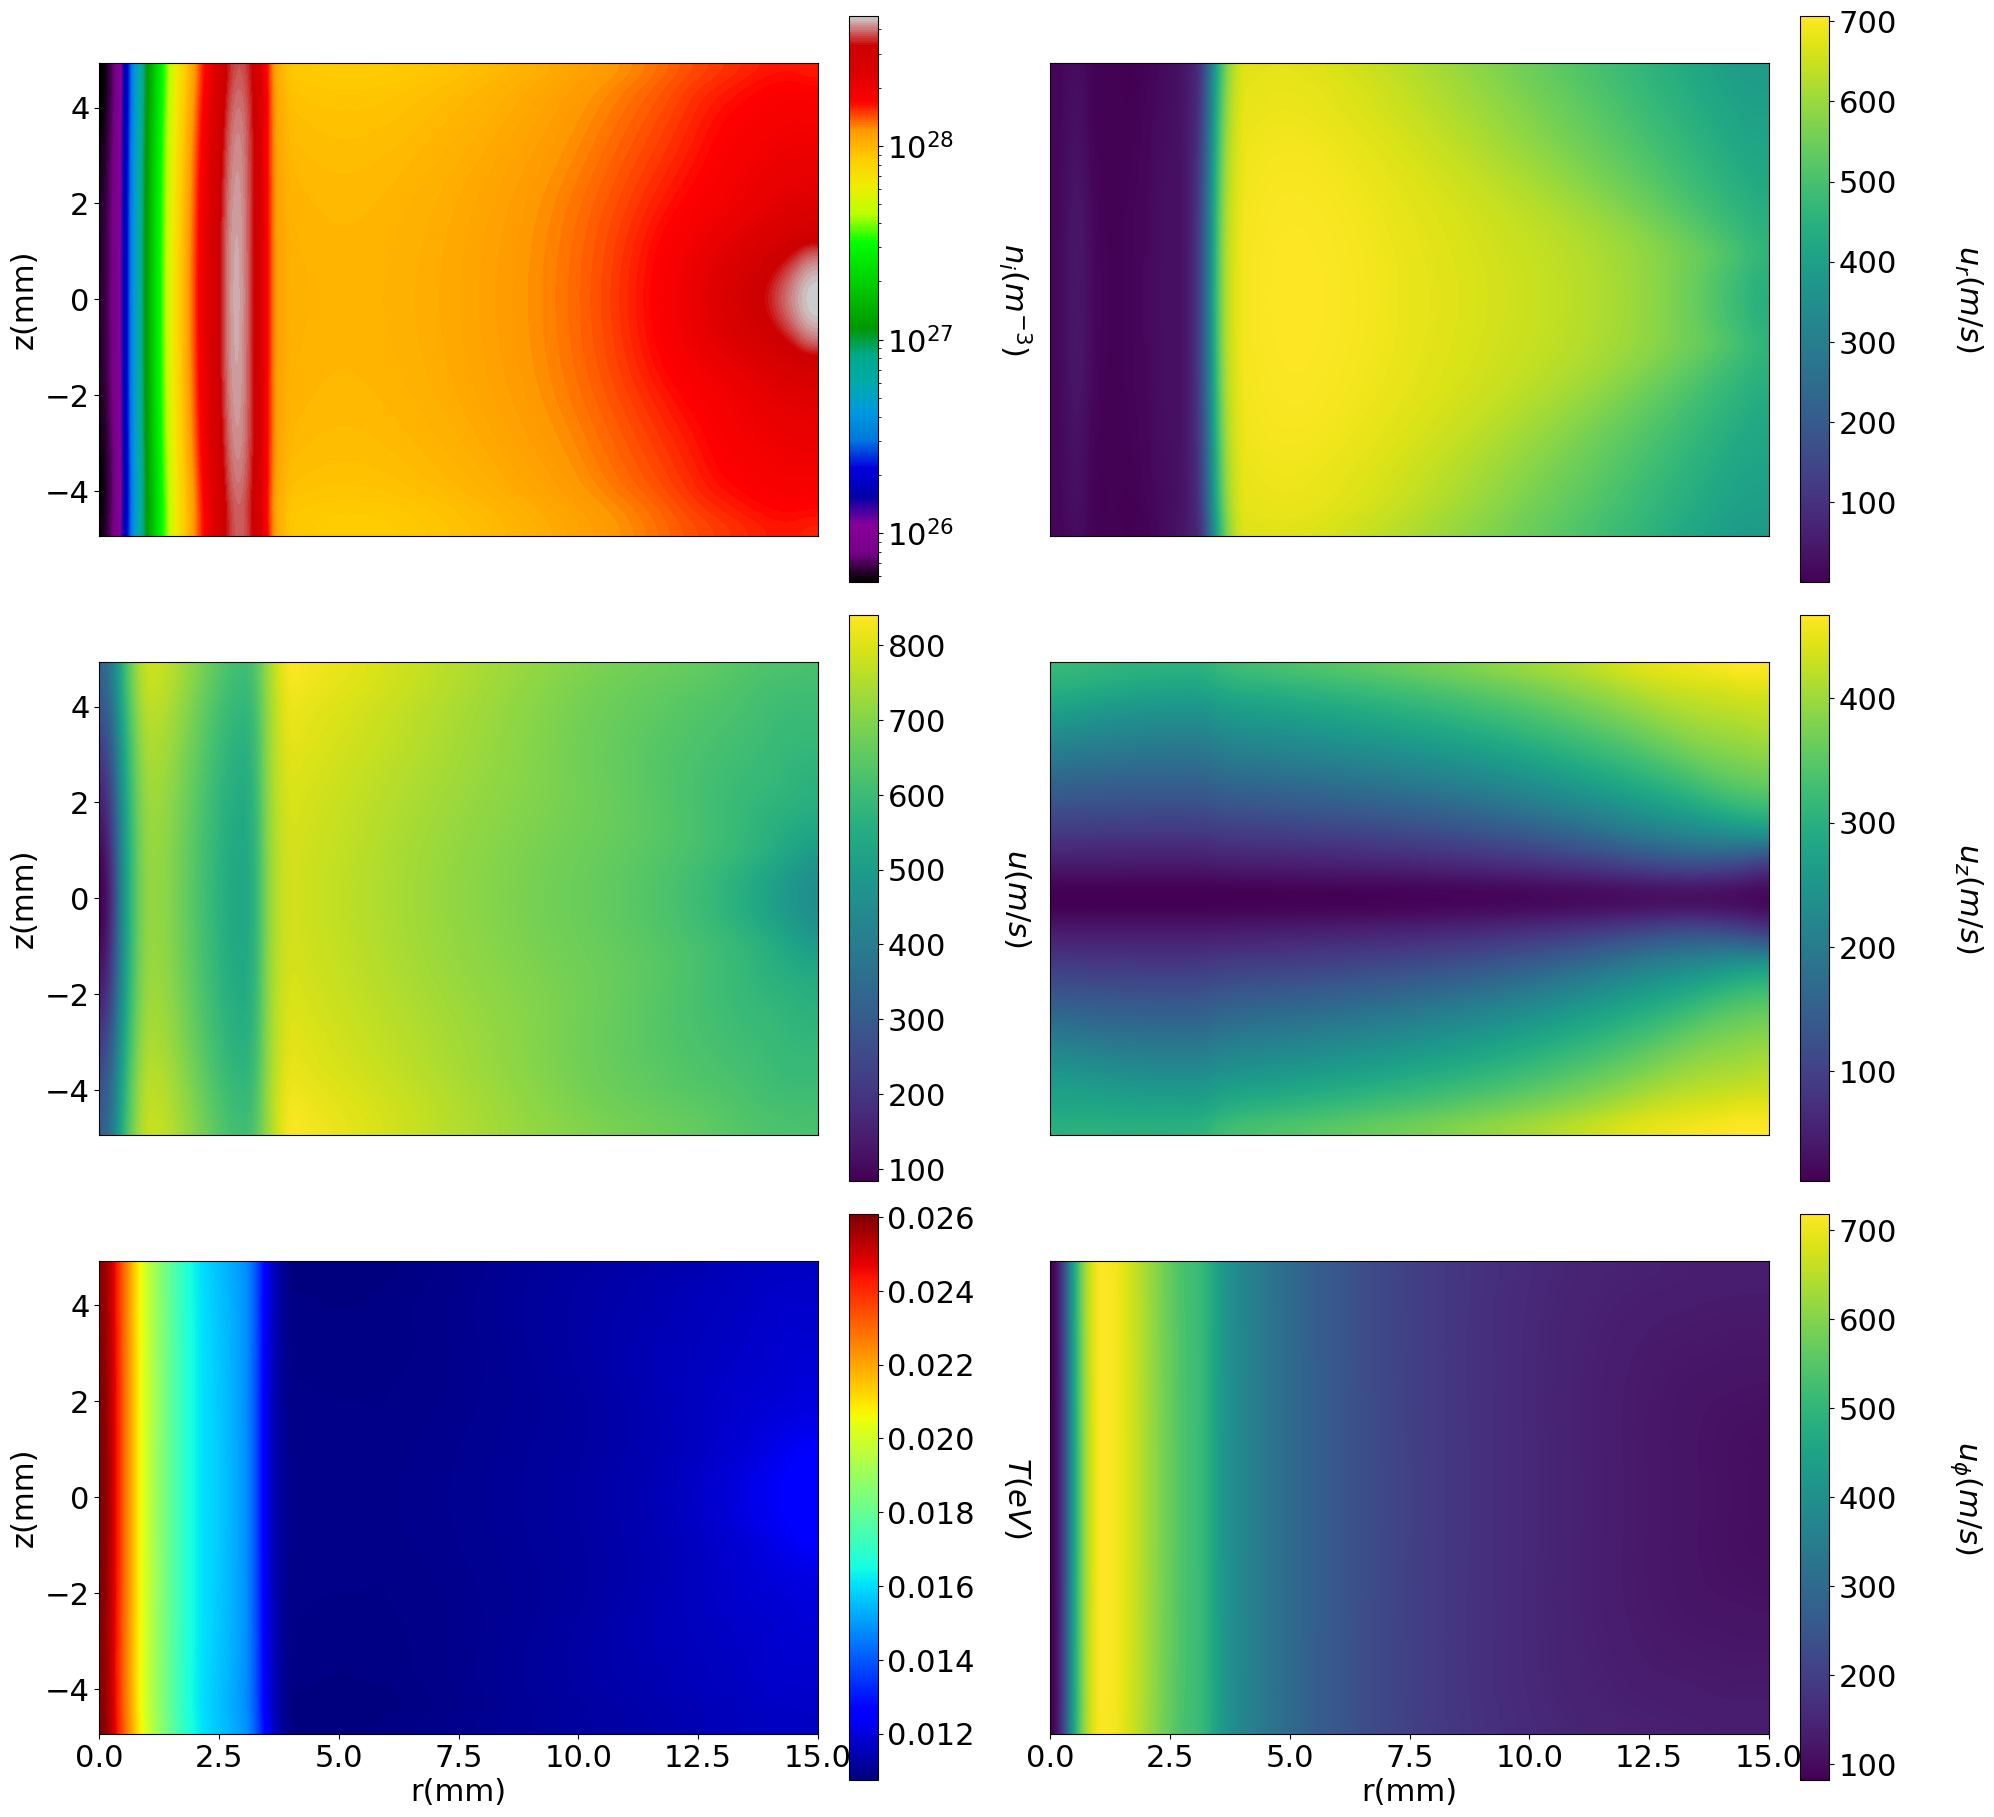

DONE


In [44]:
while t<tf:
    dt=get_min_dt(Q) #compute the optimal dt

    set_bc(Q,t) #compute the boundary cnditions
    sources=get_sources(Q) #compute the sources
    flux_x,flux_y=get_flux(Q) #and ten the fluxes
    Q1=advance_time_level(Q,flux_x,flux_y,sources) #advance the solution
    limit_flow(Q1) #limit flows that are too fast

    set_bc(Q1,t+dt) #let's do it again
    sources=get_sources(Q1)
    flux_x,flux_y=get_flux(Q1)
    Q2=advance_time_level(Q1,flux_x,flux_y,sources)
    limit_flow(Q2)

    Q=0.5*(Q+Q2) #here we do a simple second average
    limit_flow(Q)

    n_steps+=1 #time step increased by 1
    t_count+=dt #and the time by dt

    progress_bar.value=t #we have defined some progress bars cause python is slow
    output_bar.value+=dt # we need to monitor our progress and reduce resolution if it takes too long

    if ((t==ti) or (t_count>(tf-ti)/n_out)): #everything below is plotting....
        fig=plt.figure(figsize=(20, 19))
        for i in range(1, rows+1):
            for j in range(1, columns+1):
                k=j+(i-1)*columns
                fig.add_subplot(rows, columns, k)
                if (k==1):
                    data= np.flip(np.transpose(Q[ngu:nx-ngu-1,ngu:ny-ngu-1,rh]*n0),0)
                    im = plt.imshow(data, cmap=plt.cm.nipy_spectral, norm=colors.LogNorm(vmin=data.min(), vmax=data.max()),extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$n_i(m^{-3})$', rotation=-90)
                if (k==3):
                    data=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,mx]**2
                    data+=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,my]**2
                    data+=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,mz]**2
                    data/=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,rh]**2
                    data=np.sqrt(data)*L0/t0
                    data= np.flip(np.transpose(data),0)
                    im = plt.imshow(data, extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$u(m/s)$', rotation=-90)
                if (k==2):
                    data=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,mx]**2
                    data/=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,rh]**2
                    data=np.sqrt(data)*L0/t0
                    data= np.flip(np.transpose(data),0)
                    im = plt.imshow(data, extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$u_r(m/s)$', rotation=-90)
                if (k==4):
                    data=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,my]**2
                    data/=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,rh]**2
                    data=np.sqrt(data)*L0/t0
                    data= np.flip(np.transpose(data),0)
                    im = plt.imshow(data, extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$u_z(m/s)$', rotation=-90)
                if (k==6):
                    data=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,mz]**2
                    data/=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,rh]**2
                    data=np.sqrt(data)*L0/t0
                    data= np.flip(np.transpose(data),0)
                    im = plt.imshow(data, extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$u_\phi(m/s)$', rotation=-90)
                if (k==5):
                    data=Q[ngu:nx-ngu-1,ngu:ny-ngu-1,tp]*te0
                    data= np.flip(np.transpose(data),0)
                    im = plt.imshow(data, cmap=plt.cm.jet,  extent=box)
                    cb = fig.colorbar(im,fraction=0.046, pad=0.04)
                    cb.ax.set_ylabel('$T(eV)$', rotation=-90)
                im.set_interpolation('quadric')
                cb.ax.yaxis.set_label_coords(6.5, 0.5)
                plt.gca().axes.get_yaxis().set_visible(False)
                plt.gca().axes.get_xaxis().set_visible(False)
                if (j==1):
                    plt.ylabel('z(mm)', rotation=90)
                    plt.gca().axes.get_yaxis().set_visible(True)
                if (i==rows):
                    plt.xlabel('r(mm)', rotation=0)
                    plt.gca().axes.get_xaxis().set_visible(True)
        plt.tight_layout()
        clear_output()
        output_bar.value=0
        display(progress_bar) # display the bar
        display(output_bar) # display the bar
        t_count=0
        show_inline_matplotlib_plots()
    t=t+dt

#we are now done. Let's turn off the progress bars.
output_bar.close()
del output_bar
progress_bar.close()
del progress_bar

print("DONE")